In [26]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt
import glob
import os

In [27]:
# importing json files

dfs=[]
for file in glob.glob("data/*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

df.head()

,preview,is_locked,tweet_id,sticky_comment,removal_source,link,author_flair_class,is_video_mp4,is_removed,title,...,link_metadata.twitter.parentTweet.quotedTweet.video.url,link_metadata.twitter.parentTweet.linkEmbed.image,link_metadata.twitter.parentTweet.linkEmbed.domain,link_metadata.twitter.parentTweet.linkEmbed.description,link_metadata.twitter.parentTweet.linkEmbed.title,link_metadata.twitter.parentTweet.linkEmbed.url,link_metadata.twitter.poll.options,link_metadata.twitter.poll.votes,link_metadata.twitter.poll.endTime,link_metadata.twitter.poll.winningPercentage
2,https://media.patriots.win/preview/17txVxLh4h.png,False,,0,,https://media.scored.co/post/Te1QiisbCGPR.png,,False,False,🚽 Only 17% of Americans View Radical-Left Tim Walz Positively 💩,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://media.patriots.win/preview/17txVxL8ye.png,False,1820837157554041212,0,,https://twitter.com/LauraLoomer/status/1820837157554041212,,False,False,Gwen Walz is just as crazy left as her husband 🤪,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://media.patriots.win/preview/17txVxKasX.png,False,,0,,https://thepostmillennial.com/felony-charges-against-teen-who-rode-scooter-left-skid-marks-on-spokane-pride-crosswalk-dismissed?utm_campaign=64466,,False,False,"Felony charges against teen who rode scooter, left skid marks on Spokane Pride crosswalk dismissed",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,https://media.patriots.win/preview/17txVxLhCw.png,False,,0,,https://media.patriots.win/post/cS4ZO2P9yD7f.jpeg,,False,False,Donald Trump: 17 million primary votes Kamala Harris: 0 primary votes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,https://media.patriots.win/preview/17txVxKs3q.png,False,,0,,https://media.scored.co/post/Xej4O0IbECnu.jpeg,,False,False,Break the Cycle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# slicing out only relevant columns 

selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	
df = df[selected_columns]

# Replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# Format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = pd.to_datetime(df['created_date'])


# Fix empty or ill-formed domain column
selfpost_mask = df.domain.str.match('^$')
df.loc[selfpost_mask, 'domain'] = 'self_post'

df.created_date.value_counts().sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_73800/4060232883.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)


created_date
2024-07-21     31
2024-07-22    500
2024-07-23    615
2024-07-24    585
2024-07-25    631
             ... 
2024-10-12    597
2024-10-13    607
2024-10-14    618
2024-10-15    617
2024-10-16    116
Name: count, Length: 88, dtype: int64

In [29]:
# Unpack shortened domains
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import tldextract

common_shorts = [
    "adf.ly", "adfoc.us", "amzn.to", "atominik.com", "ay.gy", "b.link", "bhpho.to", "bit.ly", "bit.do", 
    "bn.gy", "branch.io", "buff.ly", "ceesty.com", "chollo.to", "cli.re", "cli.fm", "cutt.ly", "cutt.us", 
    "db.tt", "f.ls", "fa.by", "fb.me", "flip.it", "fumacrom.com", "git.io", "geni.us", "goo.gl", "gns.io", 
    "hmm.rs", "ht.ly", "hyperurl.co", "ity.im", "intamema.com", "is.gd", "j.gs", "j.mp", "kutt.it", "ldn.im", 
    "linklyhq.com", "microify.com", "mzl.la", "nmc.sg", "nowlinks.net", "ow.ly", "prf.hn", "plu.sh", "q.gs", 
    "qr.ae", "qr.net", "rebrand.ly", "rb.gy", "rlu.ru", "rotf.lol", "s.coop", "s.id", "sh.st", "soo.gd", 
    "shortcm.xyz", "short.gy", "shortcm.xyz", "shorturl.at", "smu.sg", "smq.tc", "snip.ly", "snipr.com", 
    "snipurl.com", "snurl.com", "split.to", "surl.li", "t.co", "t.ly", "t2m.io", "tiny.cc", "tiny.pl", 
    "tinyium.com", "tinyurl.com", "tiny.one", "tny.im", "tny.sh", "tr.im", "trib.al", "u.to", "v.gd", 
    "virg.in", "vzturl.com", "waa.ai", "washex.am", "x.co", "y2u.be", "yourwish.es", "zpr.io", "1url.com", 
    "2.gp", "3.ly", "4sq.com", "6url.com", "7.ly", "9.bb", "amp.gs", "atz.bz", "binged.it",
    "budurl.com", "cort.as", "decenturl.com", "dft.ba", "goo.gl", "inbound.org", "itsh.bo", "mcaf.ee",
    "n.pr", "nyti.ms", "on.fb.me", "prsm.tc", "redd.it", "tnw.to", "twt.fi", "u.nu", "virl.io", "wapo.st",
    "wp.me", "xrl.us",  "zurl.ws", "dlvr.it", 'msft.it', "lnkd.in ", 'spr.ly', 'rebelne.ws', 'scroll.in', 'ab.co',
    'hubs.li', 'bbc.in', 'nature.ly', 'cbsn.ws' , 'brnw.ch', 'youtu.be'
                ]

# Set up a Requests session with retries
session = requests.Session()
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',
    'referer': 'https://www.google.com/'
}

headers = {
        'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
        'referer':'https://google.com',
        'DNT':'1'
    }

# session.headers.update(headers)
retries = Retry(total=4, backoff_factor=1, status_forcelist=[502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

def check_connection(host='http://www.google.com'):
    try:
        session.get(host, timeout=1)
        return True
    except (requests.ConnectionError, requests.Timeout):
        return False

def wait_for_connection(interval=30, max_attempts=10):
    attempts = 0
    while not check_connection() and attempts < max_attempts:
        time.sleep(interval)
        attempts += 1
    return attempts < max_attempts

def resolve_url_head(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = requests.head(short_url, allow_redirects=True, timeout=1)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    
def resolve_url_get(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(short_url, allow_redirects=True, timeout=5)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(url=shortend_url, allow_redirects=True, timeout=1)        
   
    except requests.RequestException:
        return None    
    
df['domain'] = df['domain'].apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix if x != 'self_post' else 'self_post')
short_mask = df['domain'].isin(common_shorts)
df.loc[short_mask, 'domain'] = df.loc[short_mask, 'link'].apply(lambda x: resolve_url_get(x)).apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix)

In [30]:
# The top 10 most-shared domains on The Ronald's landing page
df.domain.value_counts(normalize=True).head(10)

domain
twitter.com             0.360871
scored.co               0.274643
patriots.win            0.143789
self_post               0.035343
thegatewaypundit.com    0.020944
youtube.com             0.018166
videy.co                0.010691
breitbart.com           0.009549
rumble.com              0.008826
zerohedge.com           0.007666
Name: proportion, dtype: float64

In [31]:
# Drop posts from 2024-07-21
df = df[df['created_date'] != '2024-07-21']

# Keep only the top 500 posts by "score_up" from each date so that the playing field is more leveled
df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)

df.groupby('created_date')['score_up'].min().sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_73800/960602510.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)


created_date
2024-07-22    42
2024-07-23    67
2024-07-24    56
2024-07-25    57
2024-07-26    49
              ..
2024-10-12    33
2024-10-13    38
2024-10-14    49
2024-10-15    44
2024-10-16    22
Name: score_up, Length: 87, dtype: int64

In [32]:
df.groupby('created_date')['score_up'].min().sort_index()

created_date
2024-07-22    42
2024-07-23    67
2024-07-24    56
2024-07-25    57
2024-07-26    49
              ..
2024-10-12    33
2024-10-13    38
2024-10-14    49
2024-10-15    44
2024-10-16    22
Name: score_up, Length: 87, dtype: int64

In [33]:
# Extract twitter handles 
df[df.domain =='twitter.com'].link.str.split('/').str[3].str.lower()
df.loc[df.domain == 'twitter.com', 'twitter_handle'] = df[df.domain == 'twitter.com'].link.str.split('/').str[3].str.lower()
df['twitter_handle'].fillna(np.nan, inplace=True)

# Top twitter handles mentioned
df.value_counts('twitter_handle', ascending=False).head(10)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_73800/3006735851.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['twitter_handle'].fillna(np.nan, inplace=True)


twitter_handle
elonmusk        577
behizytweets    529
endwokeness     441
libsoftiktok    336
trumpwarroom    270
bennyjohnson    225
nicksortor      194
collinrugg      187
dc_draino       184
immeme0         183
Name: count, dtype: int64

In [34]:
df.created

0       2024-07-22 21:37:08.297000-04:00
1       2024-07-22 14:07:56.522000-04:00
2       2024-07-22 02:27:55.264000-04:00
3       2024-07-22 13:41:37.980000-04:00
4       2024-07-22 01:18:06.352000-04:00
                      ...               
43111   2024-10-16 04:04:11.514000-04:00
43112   2024-10-16 04:23:49.935000-04:00
43113   2024-10-16 05:06:46.204000-04:00
43114   2024-10-16 05:23:11.108000-04:00
43115   2024-10-16 05:49:01.244000-04:00
Name: created, Length: 43116, dtype: datetime64[ns, US/Eastern]

In [35]:
# A function that returns the top posts in interactive format
    
def top_posts_lastNdays(num, Ndays, save_table=False):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=Ndays)
    top_posts = df[df.created_date >= start_date].nlargest(num,'score_up')
    top_posts['post_link'] = "https://patriots.win/p/" + top_posts['uuid']
    top_posts['title'] = top_posts.apply(lambda row: f'<a href="{row["post_link"]}">{row["title"]}</a>', axis=1)
    top_posts = top_posts[['title', 
                           'score_up', 
                           'comments', 
                           'author'
                           ]]
    
    
    top_posts = top_posts.reset_index().drop(columns='index')
    top_posts.index = np.arange(1, len(top_posts)+1)

    if save_table:
        html_content = top_posts.to_html(render_links=True, 
                                         justify='center', 
                                         escape=False,
                                         classes='table table-striped table-hover', 
                                         table_id='my_table')
        
        with open(f'viz/most_popular_posts_in_the_last_day(s).html', "w") as html_file:
            html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable();
                }} );
                </script>
                </head>
                <body>
                {html_content}
                </body>
                </html>
            """)
                                         
    return top_posts


top_posts_lastNdays(num=20, Ndays=1, save_table=True)

,title,score_up,comments,author
1,"<a href=""https://patriots.win/p/199OBAIPEu"">She likes Venn diagrams. </a>",959,52,DeusVult1096
2,"<a href=""https://patriots.win/p/199OBAIPF3"">Biden: ""She beat Trump so badly in the debate, he's scared to death to BEAT HER again."" </a>",788,76,I-am-Orlando
3,"<a href=""https://patriots.win/p/199OBAI87p"">LIVE: JD Vance Joining Moms for America Town Hall in Philly (JD is on stage)</a>",729,16,DeusVult1096
4,"<a href=""https://patriots.win/p/199OBAIxTG"">President Trump: We are going to FIRE Kamala and Save America. We will teach our children to love our country. We will cut your taxes and crush inflation. We will hire American, buy American, and build in America. We will turn the U.S. into a manufacturing superpower. We will prevent World War III.</a>",712,21,Mr_Rightside
5,"<a href=""https://patriots.win/p/199OBAIxXO"">Skin pigmentation for the win</a>",700,25,Candygram_for_Mongo
6,"<a href=""https://patriots.win/p/199OBAIg1R"">Tim Walz is a little... different\n</a>",693,137,DeusVult1096
7,"<a href=""https://patriots.win/p/199OBAIPNI"">LIVE: President Trump Delivers Remarks in Atlanta, GA - 10/15/24\n</a>",671,58,DeusVult1096
8,"<a href=""https://patriots.win/p/199OBAIxGx"">Michigan Firefighters union skips presidential endorsement in another blow to Harris.</a>",610,22,forth2win
9,"<a href=""https://patriots.win/p/199OBAJEFm"">Kari Lake: I have spoken to thousands of Arizona since the AZ US Senate debate last Wednesday—The day that ballots were supposed to be in mailboxes across Maricopa & Pima Counties. Everywhere I go half of the voters have not received theirballots yet. \r\n\r\nI’ve never seen this happen before. </a>",550,66,I-am-Orlando
10,"<a href=""https://patriots.win/p/199OBAJVEm"">🥔 Biden Suggests He Wants Trump in Prison — After Kamala Warns Trump Will Prosecute Opponents ⛓️</a>",490,33,MythArcana


In [36]:
def top_authors_lastNdays(num, Ndays):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=Ndays)

    return df[df.created_date >=  start_date].author.value_counts().head(num)

top_authors_lastNdays(num=10, Ndays=1)

author
forth2win              19
Tcrussell               7
I-am-Orlando            7
Mr_Rightside            5
DeusVult1096            4
MAGA_____bitches        4
kek_saved_the_world     4
MythArcana              3
JTIM                    3
Belleoffreedom          3
Name: count, dtype: int64

In [37]:
import spacy
import nltk
nltk.download('wordnet')
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words) 
stopwords.extend(["ago", 'old'])

import contractions
import emoji
import re



def clean_it_all_up (text, extra_stops):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\n', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords 
            and (extra_stops is None or token.text.lower() not in extra_stops) 
            # and token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} 
            # and token.ent_type_ not in {'GPE', 'LOC'}
            and token.pos_ not in {"AUX",
                                   "ADP",
                                   "CONJ", 
                                   "CCONJ", 
                                   "DET", 
                                   "INTJ", 
                                   "PART", 
                                   "PUNCT",
                                   "SCONJ", 
                                   "SYM", 
                                   "X", 
                                   "SPACE"}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keenansmacbookairm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [39]:
def ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    
    date_list = date_selection(start_date, end_date)

    cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())

    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head(top_n)
    return ngram


In [40]:
# Function of returning top ngrams from the past 24 hours

def ngram_generator_24hrs(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=1)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [41]:
dataframe = df
num = 2
top_n = 50
extra_stops=['trump']

top_50_bigrams_24hours = ngram_generator_24hrs(dataframe= dataframe, num=num, top_n=top_n, extra_stops=extra_stops )
top_50_bigrams_24hours

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_73800/2951235605.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())


(kamala, harris)         29
(black, man)             11
(liz, cheney)             9
(election, official)      9
(new, york)               7
(biden, harris)           6
(mark, cuban)             5
(town, hall)              5
(cassidy, hutchinson)     5
(joe, biden)              5
(2024, election)          5
(york, times)             5
(bill, clinton)           5
(jd, vance)               5
(tim, walz)               5
(united, states)          5
(georgia, rule)           4
(mark, halperin)          4
(harris, win)             4
(poll, worker)            4
(nazi, flag)              4
(hutchinson, s)           4
(absentee, ballot)        4
(harris, biden)           4
(bret, baier)             4
(november, 5th)           4
(illegal, alien)          4
(official, certify)       4
(street, artist)          4
(certify, result)         4
(north, carolina)         4
(billionaire, howard)     3
(host, verbally)          3
(corrupt, judge)          3
(laken, riley)            3
(stun, billionaire) 

In [42]:
top_50_bigrams_24hours_df = pd.DataFrame(top_50_bigrams_24hours).reset_index()

top_50_bigrams_24hours_df.index = np.arange(1, len(top_50_bigrams_24hours_df)+1)

top_50_bigrams_24hours_df.rename(columns={"index":'bigrams', 'count':'frequncy'}, inplace=True)

top_50_bigrams_24hours_df

,bigrams,frequncy
1,"(kamala, harris)",29
2,"(black, man)",11
3,"(liz, cheney)",9
4,"(election, official)",9
5,"(new, york)",7
6,"(biden, harris)",6
7,"(mark, cuban)",5
8,"(town, hall)",5
9,"(cassidy, hutchinson)",5
10,"(joe, biden)",5


In [43]:
def save_interactive_table(dataframe, save_filename):
    html_content = dataframe.to_html(render_links=True, 
                                         justify='center', 
                                         escape=False,
                                         classes='table table-striped table-hover', 
                                         table_id='my_table')
    with open(f'viz/{save_filename}.html', "w") as html_file:
         html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable();
                }} );
                </script>
                </head>
                <body>
                {html_content}
                </body>
                </html>
            """)
         
         return html_content

In [44]:
html_content = save_interactive_table(top_50_bigrams_24hours_df, 'top_bigrams_24hrs_table')

html_content

'<table border="1" class="dataframe table table-striped table-hover" id="my_table">\n  <thead>\n    <tr style="text-align: center;">\n      <th></th>\n      <th>bigrams</th>\n      <th>frequncy</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>1</th>\n      <td>(kamala, harris)</td>\n      <td>29</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>(black, man)</td>\n      <td>11</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>(liz, cheney)</td>\n      <td>9</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>(election, official)</td>\n      <td>9</td>\n    </tr>\n    <tr>\n      <th>5</th>\n      <td>(new, york)</td>\n      <td>7</td>\n    </tr>\n    <tr>\n      <th>6</th>\n      <td>(biden, harris)</td>\n      <td>6</td>\n    </tr>\n    <tr>\n      <th>7</th>\n      <td>(mark, cuban)</td>\n      <td>5</td>\n    </tr>\n    <tr>\n      <th>8</th>\n      <td>(town, hall)</td>\n      <td>5</td>\n    </tr>\n    <tr>\n      <th>9</th>\n      <td>(cassidy, hutchinson)<

In [45]:
# A function of returning top ngrams from the past 7 days

def ngram_generator_7days(dataframe, num, extra_stops, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)

In [46]:
# A function to return a wordcloud chart covering a specific period of dates
from wordcloud import WordCloud

def ngram_cloud(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    ngram = ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gist_stern').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [47]:
f"{datetime.datetime.now():%Y-%m-%d %H:%M}"


'2024-10-16 02:52'

In [48]:
# A function to return a wordcloud chart covering ONLY the past 24 hours

def ngram_24hrs_cloud(dataframe, num, save_viz, extra_stops, set_title=False, top_n=None):
    ngram = ngram_generator_24hrs(dataframe, num, extra_stops, top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, 
               interpolation='nearest',
               aspect="auto"
               )
    
    if set_title:
        plt.title(f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M}",
                fontsize=20,
                pad=10,
                style= "italic",
                loc='center'
                )
    plt.axis('off')
    plt.tight_layout()

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_73800/2951235605.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  cleaned_tokens = ' '.join(dataframe[dataframe.created_date.isin(date_list)]['title'].apply(lambda x: clean_it_all_up(x, extra_stops)).tolist())


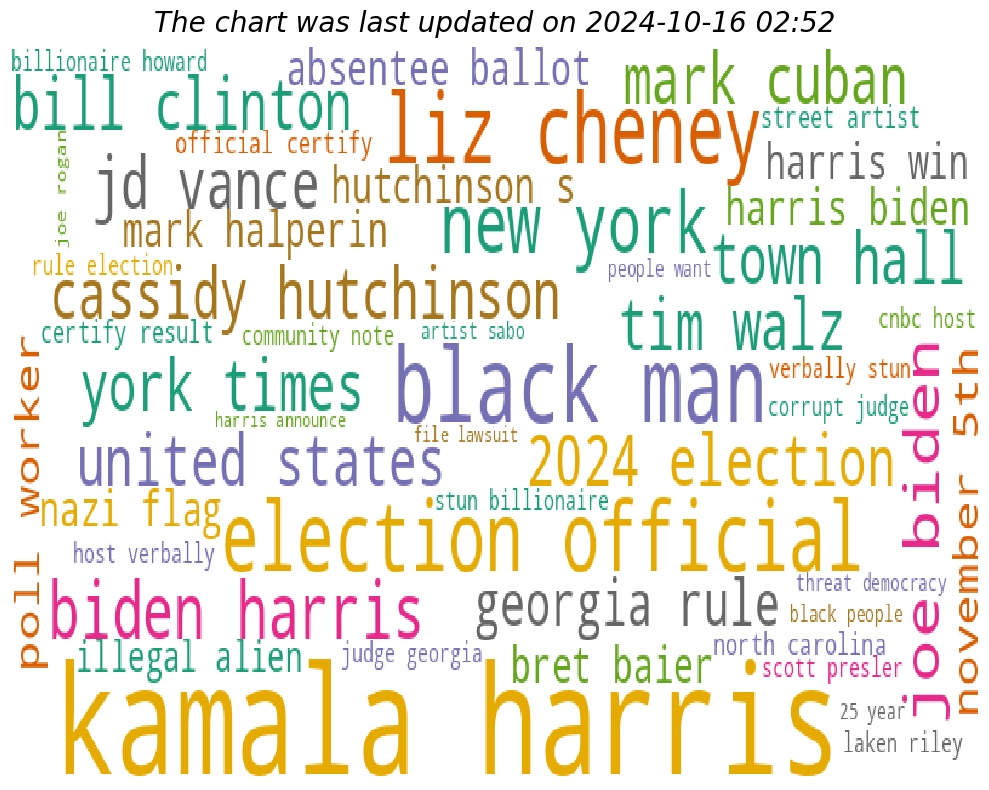

In [49]:
# creating and saving the top 50 bigrams from the last 24 hours
dataframe = df
num = 2
top_n = 50
save_viz = 'bigrams_wordcloud_24hrs'
extra_stops=['trump']
set_title=True
ngram_24hrs_cloud(dataframe = dataframe, num=num, top_n=top_n, save_viz=save_viz, set_title=set_title, extra_stops=extra_stops)



In [50]:
# A function to return a wordcloud chart covering ONLY the past 7 days

def ngram_7days_cloud(dataframe, num, save_viz, extra_stops, top_n=None):
    ngram = ngram_generator_7days(dataframe, num, extra_stops, top_n=None)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top {top_n} bigrams in the last 7 days",
              fontsize=20,
              pad=25,
              )

    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

In [51]:
# A summary table of authors based on a given date
def top_acounts(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    top_authors = dataframe[dataframe['created_date'].isin(date_list)]['author'].value_counts().reset_index()
    top_authors = top_authors[top_authors['count']>1]
    comments_total = dataframe.groupby('author').comments.sum()
    upvotes_total = dataframe.groupby('author').score_up.sum()
    top_authors =  top_authors.merge(comments_total, on='author').merge(upvotes_total, on='author')
    top_authors = top_authors.rename(columns={
                                        'author': 'top_authors',
                                        'count' : 'posts',
                                        'comments': 'accumulated_comments',
                                        'score_up': 'accumulated_upvotes'
                                        })
    top_authors = top_authors.sort_values('posts', ascending=False).head(top_n)
    return  top_authors

In [52]:
# This function returns the most posted domains from a specific period of time

def top_domains(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    top_urls = dataframe[dataframe['created_date'].isin(date_list)]['domain'].value_counts(dropna=False, normalize=True).head(top_n)
    return top_urls

In [53]:
# This function returns the most posted domains from the last 7 days

def top_domains_7days(dataframe, top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    date_list = date_selection(start_date, end_date)
    top_urls = dataframe[dataframe['created_date'].isin(date_list)]['domain'].value_counts(dropna=False, normalize=True).head(top_n)
    return top_urls

In [54]:
# Popular Twitter accounts on The Ronald

def top_xitter(dataframe, start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    xiter_accounts = dataframe[(dataframe.link.str.contains('twitter.com'))& (dataframe['created_date'].isin(date_list))]
    top_xitter = xiter_accounts['link'].str.split('/').str[3].str.lower().value_counts(normalize=False, dropna=False).head(top_n)
    return top_xitter

In [55]:
# A date-based n-gram generator
# useful for making time-series charts 

def new_ngram_generator(dataframe, num, start_date, end_date, extra_stops, top_n=None):
    # Filter dates
    date_list = date_selection(start_date, end_date)
    
    # Filter and process data
    filtered_df = dataframe[dataframe.created_date.isin(date_list)]
    filtered_df['cleaned_title'] = filtered_df['title'].apply(lambda x: clean_it_all_up(x, extra_stops))

    
    ngrams_with_dates = []
    
    for index, row in filtered_df.iterrows():
        tokens = row['cleaned_title'].split()
        if num ==1:
            unigrams_list = list(tokens)
            for unigram in unigrams_list:
                ngrams_with_dates.append((unigram, row['created_date']))
        elif num == 2:
            bigrams_list = list(bigrams(tokens))
            for bigram in bigrams_list:
                ngrams_with_dates.append((bigram, row['created_date']))
        elif num == 3:
            trigrams_list = list(trigrams(tokens))
            for trigram in trigrams_list:
                ngrams_with_dates.append((trigram, row['created_date']))
        else:
            raise ValueError('Invalid number. Must choose between 2 or 3.')
    
    ngram_df = pd.DataFrame(ngrams_with_dates, columns=['ngram', 'date']).head(top_n)
    return ngram_df


In [56]:
def ngram_time_series(dataframe, num, start_date, end_date, save_viz, extra_stops, top_n=None):

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    plt.figure(figsize=(10, 8))


    top_ngram_plot = sns.lineplot(data=top_ngram_pivot)

    plt.xlabel('')
    plt.ylabel('Mention count')
    plt.title(f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}')

    plt.xticks(rotation=45) 
    plt.grid(True)

    plt.legend(title='Top Bigrams', bbox_to_anchor=(1.3, 1), loc='upper right')
    
    if save_viz is not None:
        plt.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        plt.show()
    else:
        plt.show()

In [57]:
# create interactive charts with Plotly

import plotly.graph_objs as go

def ngram_time_series_interactive(dataframe, num, start_date, end_date, save_viz, extra_stops, top_n=None):
    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))

    fig.update_layout(
        width=1400,
        height=800,
        title=f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}',
        xaxis_title='Date',
        yaxis_title='Frequency',
        
        xaxis=dict(tickangle=45),
        legend_title_text='Top Bigrams'
    )

    if save_viz is not None:
        fig.savefig(f"viz/{save_viz}.jpeg",
                    dpi=600
                    )
        fig.show()
    else:
        fig.show()

In [58]:
# This function would only cover the past n days

def ngram_time_last_n_days_interactive(dataframe, num, last_ndays, extra_stops, save_filename, top_n=None):
    end_date = pd.to_datetime(dataframe['created_date'].max())
    start_date = end_date - pd.Timedelta(days=last_ndays)
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    # Prepare the data for plotting
    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    y_max = top_ngram_pivot.values.max()
    y_range = [0, y_max * 1.1]

    fig = go.Figure()

    # Add traces for each n-gram
    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)
        ))

    fig.update_traces(line={'width': 5})

    layout = dict(
        width=1000,
        height=800,
        xaxis=dict(
            title='Date',
            tickangle=45
        ),
        yaxis=dict(
            title='Frequency',
            range=y_range
        ),
        legend_title=dict(
            text='<b>Popular Bigrams<br>',
            font=dict(
                family="Courier",
                color='firebrick',
                size=15
            )
        )
    )
    

    if set_title:
        layout['title'] = dict(
            text= f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M}",
            font=dict(
                family="Arial",
                size=20
            ),
            pad=dict(t=20)
        )

    fig.update_layout(layout)

    if save_filename:
        fig.write_html(f"viz/{save_filename}.html")
    
    fig.show()

In [59]:
def ngram_time_last_7_days_interactive(dataframe, num, extra_stops, save_filename, set_title=False, top_n=None):
    end_date = pd.to_datetime(dataframe['created_date'].max())
    start_date = end_date - pd.Timedelta(days=7)
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(dataframe, num, start_date, end_date, extra_stops)

    # Prepare the data for plotting
    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    y_max = top_ngram_pivot.values.max()
    y_range = [0, y_max * 1.1]

    fig = go.Figure()

    # Add traces for each n-gram
    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)
        ))

    fig.update_traces(line={'width': 5})

    layout = dict(
        width=1000,
        height=800,
        xaxis=dict(
            title='Date',
            tickangle=45
        ),
        yaxis=dict(
            title='Frequency',
            range=y_range
        ),
        legend_title=dict(
            text='<b>Popular Bigrams<br>',
            font=dict(
                family="Courier",
                color='firebrick',
                size=15
            )
        )
    )

    margin = dict(l=0,
                  r=0,
                  t=0,
                  b=10)

    if set_title:
        layout['title'] = dict(
            text= f"The chart was last updated on {datetime.datetime.now():%Y-%m-%d %H:%M}",
            font=dict(
                family="Arial",
                size=20
            ),
            pad=dict(t=20)
        )

    fig.update_layout(layout, margin)

    if save_filename:
        fig.write_html(f"viz/{save_filename}.html")
    
    fig.show()

In [66]:
# create a separate dataframe that include only youtube-linked posts
youtube_df = df[df.domain=='youtube.com']

# a functiont that extract youtube ids from urls
def youtube_parser(url):
    # Regular expression to capture YouTube video IDs from various URL formats
    id_pattern = r'(?:https?:\/\/)?(?:[0-9A-Z-]+\.)?(?:youtube|youtu|youtube-nocookie)\.(?:com|be)\/(?:watch\?v=|watch\?.+&v=|embed\/|v\/|.+\?v=)?([^&=\n%\?]{11})'
    
    match = re.search(id_pattern, url)
    return match.group(1) if match else np.nan

# extract videos id 
youtube_df['youtube_id'] = youtube_df['link'].apply(youtube_parser)


/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_73800/3415897148.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube_df['youtube_id'] = youtube_df['link'].apply(youtube_parser)


In [189]:
# This function returns the most posted domains from the last 7 days

def youtube_last_ndays(dataframe, ndays):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=ndays)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    date_list = date_selection(start_date, end_date)
    dataframe = dataframe[dataframe['created_date'].isin(date_list)].sort_values('score_up')
    return dataframe


youtube_3days_df = youtube_last_ndays(youtube_df, 3)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_73800/2687004662.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dataframe = dataframe[dataframe['created_date'].isin(date_list)].sort_values('score_up')


In [190]:
import os
from dotenv import load_dotenv

def congfiure():
    load_dotenv()
    api_key = os.getenv('api_key')
    return api_key

In [191]:
import sys
sys.path.append("/Users/keenansmacbookairm3/Documents/GitHub/SearchTube")

from SearchTube import tube_meta

In [192]:
video_id = youtube_3days_df.youtube_id.to_list()
api_key = congfiure()

video_meta =  tube_meta(video_id, api_key)
video_meta_df = pd.DataFrame(video_meta)

Video metadata list_1 fetched
---------
Finished fetching ALL 1 chunks of video metadata


In [193]:
# A funciton to extract first paragraph from a longer chunck of text
def find_first_paragraph(text):
    first_paragraph = re.search(r'(.+?)(?:\n\s*\n|$)', text, re.DOTALL)
    return first_paragraph.group(1).strip() if first_paragraph else ''

In [194]:
# run the function on the full description
video_meta_df['brief_desription'] = video_meta_df.full_description.apply(find_first_paragraph).str.replace('\n', ' ')

# merge the two youtube dataframes
youtube_3days_df = youtube_3days_df.merge(video_meta_df, left_on='youtube_id', right_on='video_id')

In [195]:
# create a dataframe specifically for the html
display_df = youtube_3days_df[['full_title', 
                               'brief_desription', 
                               'channel_title', 
                               'link', 
                               'score_up',
                               'comments'
                               ]].sort_values('score_up', ascending=False)

# reset index 
display_df = display_df.reset_index(drop=True)

In [196]:
# export the dataframe table into html-ready format
youtube_html = display_df.to_html(render_links=True, 
                                        justify='center', 
                                        escape=False,
                                        classes='table table-striped table-hover', 
                                        table_id='my_table'
                                        )


with open(f'viz/youtube_videos_shared_onto_The_Donalds_last_3_days.html', "w") as youtube_html_file:
            youtube_html_file.write(f"""
                <html>
                <head>
                <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.21/css/jquery.dataTables.css">
                <script type="text/javascript" charset="utf8" src="https://code.jquery.com/jquery-3.5.1.js"></script>
                <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.21/js/jquery.dataTables.js"></script>
                <script>
                $(document).ready( function () {{
                    $('#my_table').DataTable();
                }} );
                </script>
                </head>
                <body>
                {youtube_html}
                </body>
                </html>
            """)